<a href="https://colab.research.google.com/github/Ataerman/LLM-gpt2-/blob/main/llm_gpt2_github.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [59]:
!pip install tiktoken   #for tokenizer
import tiktoken
import importlib
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
import torch.nn.functional as F

In [60]:
#check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("CUDA available:", torch.cuda.is_available())
print("Device name:", torch.cuda.get_device_name(0))
print("Device:", device)


CUDA available: True
Device name: NVIDIA A100-SXM4-40GB
Device: cuda


In [61]:
#read data and create dataloader
with open('/content/drive/MyDrive/Large Language Models/data/verdict.txt','r',encoding='utf-8') as f:
  text_data=f.read()
print(text_data[:20])
print(len(text_data))


I HAD always thought
20479


In [62]:
class GPTDatasetV1(Dataset):
  def __init__(self,txt,tokenizer,max_length,stride):
    self.input_ids=[]
    self.target_ids=[]

    token_ids=tokenizer.encode(txt,allowed_special={'<|endoftext|>'})

    for i in range(0,len(token_ids)-max_length,stride):
      input_chunk=token_ids[i:i+max_length]
      target_chunk=token_ids[i+1:i+max_length+1]
      self.input_ids.append(torch.tensor(input_chunk))
      self.target_ids.append(torch.tensor(target_chunk))
  def __len__(self):
    return len(self.input_ids)
  def __getitem__(self,idx):
    return self.input_ids[idx],self.target_ids[idx]
def create_dataloader_v1(txt,batch_size=4,max_length=256,stride=128,shuffle=True,drop_last=True,num_workers=0):
  tokenizer=tiktoken.get_encoding('gpt2')
  dataset=GPTDatasetV1(txt,tokenizer,max_length,stride)

  dataloader=DataLoader(
      dataset,
      batch_size=batch_size,
      shuffle=shuffle,
      drop_last=drop_last,
      num_workers=num_workers
  )
  return dataloader


In [63]:
# Define GPT-2 model configuration (124M parameters version)
GPT_CONFIG_124M = {
    'vocab_size': 50257,          # Number of tokens in GPT-2's vocabulary
    'context_length': 256,        # Maximum sequence length (window size)
    'emb_dim': 768,               # Embedding dimension (hidden size)
    'n_heads': 12,                # Number of attention heads
    'n_layers': 12,               # Number of transformer blocks (layers)
    'drop_rate': 0.1,             # Dropout rate for regularization
    'qkv_bias': True             # Whether to use bias in Q, K, V projections
}


In [64]:
#train and val loaders

train_ratio=0.90
split_idx=int(train_ratio*len(text_data))
train_data=text_data[:split_idx]
val_data=text_data[split_idx:]

torch.manual_seed(123)

train_loader=create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M['context_length'],
    stride=GPT_CONFIG_124M['context_length'],
    shuffle=True,
    drop_last=True,
    num_workers=0
)

val_loader=create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M['context_length'],
    stride=GPT_CONFIG_124M['context_length'],
    shuffle=False,
    drop_last=False,
    num_workers=0
)
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

print(len(train_loader))
print(len(val_loader))

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])
9
1


In [65]:
class MultiHeadAttention(nn.Module):
  def __init__(self,d_in,d_out,context_length,dropout,num_heads,qkv_bias=True):
    super().__init__()
    assert (d_out % num_heads==0),\
      'd_out must be divisible by num_heads'

    self.d_out=d_out
    self.num_heads=num_heads
    self.head_dim=d_out//num_heads

    self.W_query=nn.Linear(d_in,d_out,bias=qkv_bias)
    self.W_key=nn.Linear(d_in,d_out,bias=qkv_bias)
    self.W_value=nn.Linear(d_in,d_out,bias=qkv_bias)
    self.out_proj=nn.Linear(d_out,d_out)
    self.dropout=nn.Dropout(dropout)
    self.register_buffer("mask",torch.triu(torch.ones(context_length,context_length),diagonal=1))

  def forward(self,x):
    b,num_tokens,d_in=x.shape

    keys=self.W_key(x)  #shape:(b,num_tokens,d_out)(2,4,6 (if num_heads==2))
    queries=self.W_query(x)
    values=self.W_value(x)

    #(b,num_tokens,d_out)>(b,num_tokens,num_heads,head_dim)(2,4,6 > 2,4,2,3)
    keys=keys.view(b,num_tokens,self.num_heads,self.head_dim)
    queries=queries.view(b,num_tokens,self.num_heads,self.head_dim)
    values=values.view(b,num_tokens,self.num_heads,self.head_dim)

    keys=keys.transpose(1,2)   #(b,num_tokens,num_heads,head_dim)>(b,num_heads,num_tokens,head_dim)
    values=values.transpose(1,2)
    queries=queries.transpose(1,2)

    attn_scores=queries @ keys.transpose(2,3) #(b,num_heads,num_tokens,head_dim) @ ((b,num_heads,head_dim,num_tokens))
    #attn_score.shape=(b,num_heads,num_tokens,num_tokens)

    mask_bool=self.mask.bool()[:num_tokens,:num_tokens] #Applying masking
    attn_scores = attn_scores.masked_fill(mask_bool, -torch.inf)



    attn_weights=torch.softmax(attn_scores/keys.shape[-1]**0.5,dim=-1) #applying scale and softmax
    attn_weights=self.dropout(attn_weights)

    context_vec=(attn_weights@values).transpose(1,2) #-->(b,num_tokens,num_heads,head_dim)
    context_vec=context_vec.contiguous().view(b,num_tokens,self.d_out) #(b,num_tokens,self.d_out)
    context_vec=self.out_proj(context_vec)

    return context_vec

In [66]:
# #testing
# d_in = d_out = 768
# context_length = 8
# num_heads = 12
# dropout = 0.0
# x = torch.randn(2, context_length, d_in)
# attn = MultiHeadAttention(
#     d_in=d_in,
#     d_out=d_out,
#     context_length=context_length,
#     dropout=dropout,
#     num_heads=num_heads,
#     qkv_bias=True)
# with torch.no_grad():
#     out = attn(x)
# print("Girdi boyutu :", x.shape)
# print("Çıktı boyutu :", out.shape)


In [67]:
class LayerNorm(nn.Module):
  def __init__(self,emb_dim):
    super().__init__()
    self.eps=1e-5
    self.scale=nn.Parameter(torch.ones(emb_dim))
    self.shift=nn.Parameter(torch.zeros(emb_dim))
  def forward(self,x):
    mean=x.mean(dim=-1,keepdim=True) #dim=-1 for columns keepdim = keep dimensions
    var=x.var(dim=-1,keepdim=True,unbiased=False) #unbiased=False = // n    not n-1 for var
    norm_x=(x-mean)/torch.sqrt(var+self.eps)
    return self.scale*norm_x+self.shift
class Gelu(nn.Module):
  def __init__(self):
    super().__init__()
  def forward(self,x):
    return 0.5*x*(1+torch.tanh(torch.sqrt(torch.tensor(2.0/torch.pi))*(x+0.044715*torch.pow(x,3))))
class FeedForward(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.layers=nn.Sequential(
        nn.Linear(cfg['emb_dim'],4*cfg['emb_dim']),
        Gelu(),
        nn.Linear(4*cfg['emb_dim'],cfg['emb_dim'])
    )
  def forward(self,x):
    return self.layers(x)

In [68]:
class TransformerBlock(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.att=MultiHeadAttention(
        d_in=cfg['emb_dim'],
        d_out=cfg['emb_dim'],
        context_length=cfg['context_length'],
        num_heads=cfg['n_heads'],
        dropout=cfg['drop_rate'],
        qkv_bias=cfg['qkv_bias'])
    self.ff=FeedForward(cfg)
    self.norm1=LayerNorm(cfg['emb_dim'])
    self.norm2=LayerNorm(cfg['emb_dim'])
    self.drop_shortcut=nn.Dropout(cfg['drop_rate'])

  def forward(self,x):
    shortcut=x
    x=self.norm1(x)
    x=self.att(x)
    x=self.drop_shortcut(x)
    x=x+shortcut

    shortcut=x
    x=self.norm2(x)
    x=self.ff(x)
    x=self.drop_shortcut(x)
    x=x+shortcut

    return x

In [69]:
class GPTModel(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.tok_emb=nn.Embedding(cfg['vocab_size'],cfg['emb_dim'])
    self.pos_emb=nn.Embedding(cfg['context_length'],cfg['emb_dim'])
    self.drop_emb=nn.Dropout(cfg['drop_rate'])
    self.trf_blocks=nn.Sequential(
        *[TransformerBlock(cfg) for _ in range(cfg['n_layers'])])
    self.final_norm=LayerNorm(cfg['emb_dim'])
    self.out_head=nn.Linear(cfg['emb_dim'],cfg['vocab_size'],bias=False)
  def forward(self,in_idx):
    batch_size,seq_length=in_idx.shape
    tok_embeds=self.tok_emb(in_idx)
    pos_embeds=self.pos_emb(torch.arange(seq_length,device=in_idx.device))
    x=tok_embeds+pos_embeds
    x=self.drop_emb(x)
    x=self.trf_blocks(x)
    x=self.final_norm(x)
    logits=self.out_head(x)
    return logits

In [70]:
model=GPTModel(GPT_CONFIG_124M)
model.eval()
tokenizer = tiktoken.get_encoding('gpt2')
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)  # (batch_size, seq_len)
    return encoded_tensor
def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)
    return tokenizer.decode(flat.tolist())
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]  # last token prediction
        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1].unsqueeze(-1)
            logits = torch.where(logits < min_val, torch.full_like(logits, float('-inf')), logits)

        if temperature > 0.0:
            logits = logits / temperature
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)
        if eos_id is not None:
            if (idx_next == eos_id).all():
                break
        idx = torch.cat((idx, idx_next), dim=1)
    return idx

In [73]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of parameters: {total_params:,}")
#out_head.w=tok_emb.w so 162-38 almost 124M params

Number of parameters: 162,447,360


In [74]:
def calc_loss_batch(input_batch,target_batch,model,device):
  input_batch,target_batch=input_batch.to(device),target_batch.to(device)
  logits=model(input_batch)
  logits=logits.flatten(0,1)
  targets=target_batch.flatten()
  loss=torch.nn.functional.cross_entropy(logits,targets)
  return loss
def calc_loss_loader(data_loader, model, device, num_batches=None):
    model.eval()
    total_loss = 0.
    if len(data_loader) == 0:
        return float('nan')
    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    with torch.no_grad():
        for i, (input_batch, target_batch) in enumerate(data_loader):
            if i < num_batches:
                loss = calc_loss_batch(input_batch, target_batch, model, device)
                total_loss += loss.item()
            else:
                break
    model.train()
    return total_loss / num_batches

In [75]:
def train_model_simple(model,train_loader,val_loader,optimizer,device,num_epochs,
                        eval_freq,eval_iter,start_context,tokenizer):
  train_losses,val_losses,track_tokens_seen=[],[],[]
  tokens_seen,global_step=0,-1

  for epoch in range(num_epochs):
    model.train()
    for input_batch,target_batch in train_loader:
      optimizer.zero_grad()
      loss=calc_loss_batch(input_batch,target_batch,model,device)
      loss.backward()
      optimizer.step()
      tokens_seen+=input_batch.numel()
      global_step +=1

      if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")
    generate_and_print_sample(model,tokenizer,device,start_context)
  return train_losses, val_losses, track_tokens_seen
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

In [76]:
import time
start_time = time.time()

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 100
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

# Note:
# Uncomment the following code to show the execution time
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 9.811, Val loss 9.936
Ep 1 (Step 000005): Train loss 8.081, Val loss 8.300
Every effort moves you,,, the,,,, the, the, the, the,,,,,, the, the,, the, the,, the,,, the, the,, the,, the,,, the, the
Ep 2 (Step 000010): Train loss 6.693, Val loss 7.076
Ep 2 (Step 000015): Train loss 6.069, Val loss 6.572
Every effort moves you, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and
Ep 3 (Step 000020): Train loss 5.439, Val loss 6.493
Ep 3 (Step 000025): Train loss 5.579, Val loss 6.430
Every effort moves you I                                                 
Ep 4 (Step 000030): Train loss 5.283, Val loss 6.447
Ep 4 (Step 000035): Train loss 5.109, Val loss 6.392
Every effort moves you, I was.                                              
Ep 5 (Step 000040): Train loss 4.334, Val loss 6.286
Every effort moves you.            "I he was the fact--I had been.      "I I was he was the and I had b

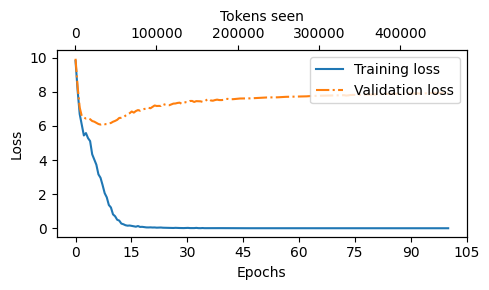

In [77]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [78]:
# --- Save checkpoint (Google Drive'a) ---
checkpoint = {
    'epoch': num_epochs,  # İstersen son epoch'u da kaydedebilirsin
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}

torch.save(checkpoint, '/content/drive/MyDrive/gptmodel_checkpoint.pth')
print("Checkpoint saved to Drive!")

# --- Save full model (Google Drive'a) ---
torch.save(model, '/content/drive/MyDrive/gptmodel_full.pth')
print("Full model saved to Drive!")


Checkpoint saved to Drive!
Full model saved to Drive!
